In [ ]:
import keras
from keras.datasets import mnist
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import random
import pandas as pd
import seaborn as sn

In [ ]:
import imgaug.augmenters as iaa
import cv2
from google.colab.patches import cv2_imshow
import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Acquisition des images

In [ ]:
targets = []
images_paper = []
images_trash = []

In [ ]:
#/content/drive/MyDrive/GMC1041/data2
images_paper_path = glob.glob("/content/drive/MyDrive/GMC1041/dataset_papertrash/paper/*.jpg")
images_trash_path = glob.glob("/content/drive/MyDrive/GMC1041/dataset_papertrash/trash/*.jpg")

In [ ]:
for img_path in images_paper_path:
    img = cv2.imread(img_path)
    img = cv2.resize(img,(250,250))
    images_paper.append(img)

for img_path in images_trash_path:
    img = cv2.imread(img_path)
    img = cv2.resize(img,(250,250))
    images_trash.append(img)

In [ ]:
print(np.asarray(images_paper).shape)
print(np.asarray(images_trash).shape)

(594, 250, 250, 3)
(274, 250, 250, 3)


In [ ]:
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Flipud(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (1.2, 1.4), "y": (1.2, 1.4)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-15, 15),
        shear=(0, 8)
    )
], random_order=True) # apply augmenters in random order


In [ ]:
# 3. augmented_images
times = 2
new_images_paper = images_paper
new_images_trash = images_trash

for _ in range(times):
    augmented_images_paper = augmentation(images=images_paper)
    augmented_images_trash1 = augmentation(images=images_trash)
    augmented_images_trash2 = augmentation(images=images_trash)
    new_images_paper =new_images_paper + augmented_images_paper
    new_images_trash =new_images_trash + augmented_images_trash1 + augmented_images_trash2


'\nfor _ in range(times):\n    augmented_images_paper = augmentation(images=images_paper)\n    augmented_images_trash1 = augmentation(images=images_trash)\n    augmented_images_trash2 = augmentation(images=images_trash)\n    new_images_paper =new_images_paper + augmented_images_paper\n    new_images_trash =new_images_trash + augmented_images_trash1 + augmented_images_trash2\n'

In [ ]:
print(np.asarray(new_images_paper).shape[0])
print(np.asarray(new_images_trash).shape[0])

594
274


# Visualisation d'image

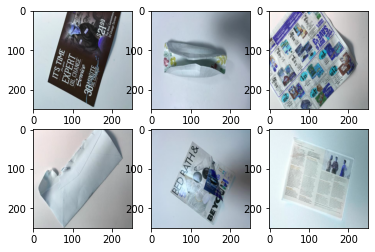

In [ ]:
from random import randint
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(new_images_paper[randint(0,np.asarray(new_images_paper).shape[0])])
    plt.show

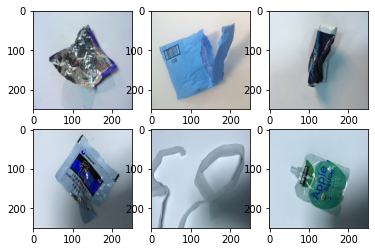

In [ ]:
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(new_images_trash[randint(0,np.asarray(new_images_trash).shape[0])])
    plt.show

# preprocessing

In [ ]:
feature_paper = np.asarray(new_images_paper)
feature_trash = np.asarray(new_images_trash)

In [ ]:
targets_paper = np.zeros((feature_paper.shape[0],),dtype=int)
targets_trash = np.ones((feature_trash.shape[0],),dtype=int)

In [ ]:
X = np.concatenate((feature_paper,feature_trash), axis = 0)
print(X.shape)
Y = np.concatenate((targets_paper,targets_trash), axis = 0)
print(Y.shape)

(868, 250, 250, 3)
(868,)


In [ ]:
n_values = np.max(Y) + 1
Y = np.eye(n_values)[Y]

# Jeu de validation

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_X,test_X,train_Y,test_Y = train_test_split(X, Y, test_size = 0.15, random_state = 5)

In [ ]:
print(train_X.shape)
print(test_X.shape)
print(train_Y.shape)
print(test_Y.shape)

(737, 250, 250, 3)
(131, 250, 250, 3)
(737, 2)
(131, 2)


# Creation du modele

In [ ]:
model = Sequential()

model.add(Conv2D(64, (3, 3), input_shape=(train_X[0].shape)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(16, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(8))

model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(loss = keras.losses.categorical_crossentropy, optimizer = keras.optimizers.Adam(), metrics = ['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 248, 248, 64)      1792      
                                                                 
 activation_16 (Activation)  (None, 248, 248, 64)      0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 124, 124, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 122, 122, 32)      18464     
                                                                 
 activation_17 (Activation)  (None, 122, 122, 32)      0         
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 61, 61, 32)       0         
 g2D)                                                 

In [ ]:
es = keras.callbacks.EarlyStopping(monitor='val_accuracy',min_delta=0, patience=3, verbose=2, mode='auto',
                                  restore_best_weights=True)

In [ ]:
history = model.fit(train_X, train_Y,
                    validation_data=(test_X, test_Y),
                    batch_size=64, 
                    epochs=25,
                    callbacks=[es])

Epoch 1/25
12/12 [==============================] - 97s 8s/step - loss: 36.9640 - accuracy: 0.5807 - val_loss: 4.9014 - val_accuracy: 0.6870
Epoch 2/25
12/12 [==============================] - 93s 8s/step - loss: 5.3258 - accuracy: 0.5957 - val_loss: 3.4928 - val_accuracy: 0.6870
Epoch 3/25
12/12 [==============================] - 94s 8s/step - loss: 1.7485 - accuracy: 0.6771 - val_loss: 0.8626 - val_accuracy: 0.7405
Epoch 4/25
12/12 [==============================] - 98s 8s/step - loss: 0.4600 - accuracy: 0.8209 - val_loss: 0.5182 - val_accuracy: 0.7863
Epoch 5/25
12/12 [==============================] - 93s 8s/step - loss: 0.3881 - accuracy: 0.8277 - val_loss: 0.4458 - val_accuracy: 0.8092
Epoch 6/25
12/12 [==============================] - 99s 8s/step - loss: 0.2926 - accuracy: 0.8602 - val_loss: 0.4094 - val_accuracy: 0.8397
Epoch 7/25
12/12 [==============================] - 93s 8s/step - loss: 0.1936 - accuracy: 0.9308 - val_loss: 0.2683 - val_accuracy: 0.9008
Epoch 8/25
12/12 [=

# Evaluation de la precision

In [ ]:
test_loss, test_acc = model.evaluate(test_X, test_Y)
print('Test loss', test_loss)
print('Test accuracy', test_acc)

5/5 [==============================] - 4s 690ms/step - loss: 0.1383 - accuracy: 0.9695
Test loss 0.13825654983520508
Test accuracy 0.9694656729698181


# Graphique d'apprentissage

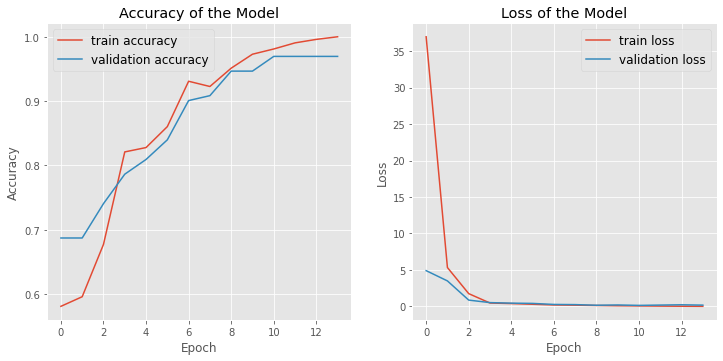

In [ ]:
plt.figure(figsize=(12, 12))
plt.style.use('ggplot')
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy of the Model')
plt.ylabel('Accuracy',fontsize=12)
plt.xlabel('Epoch',fontsize=12)
plt.legend(['train accuracy','validation accuracy'],loc='best', prop={'size':12})

plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of the Model')
plt.ylabel('Loss',fontsize=12)
plt.xlabel('Epoch',fontsize=12)
plt.legend(['train loss','validation loss'],loc='best', prop={'size':12})

# Voir une prediction

5/5 [==============================] - 4s 681ms/step
Ma prédiction est 0


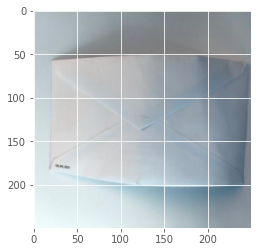

In [ ]:
def pred_and_see(idx: int): 
    predictions = model.predict(test_X)
    print('Ma prédiction est', np.argmax(np.round(predictions[idx])))

    plt.imshow(test_X[idx], cmap = plt.cm.binary)
    plt.show()

alea= np.random.randint(len(test_X))
pred_and_see(alea)

# Construction d'une matrice de confusion

In [ ]:
predictions = model.predict(test_X)

5/5 [==============================] - 4s 740ms/step


In [ ]:
np.argmax(predictions[0])

0

In [ ]:
predictions = model.predict(test_X)
test_preds = np.argmax(predictions, axis = 1)

target_names = np.arange(2)

cm = confusion_matrix(np.argmax(test_Y, axis=1), test_preds)

print(classification_report(np.argmax(test_Y, axis=1), test_preds))

5/5 [==============================] - 4s 672ms/step
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        90
           1       1.00      0.90      0.95        41

    accuracy                           0.97       131
   macro avg       0.98      0.95      0.96       131
weighted avg       0.97      0.97      0.97       131



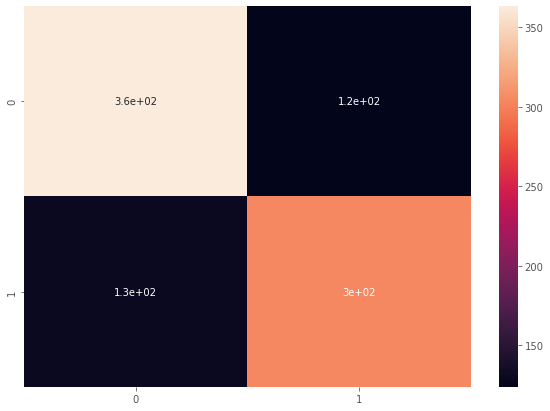

In [ ]:
df_cm = pd.DataFrame(cm,index = target_names, columns = target_names)
plt.figure(figsize=(10,7))
sn.heatmap(df_cm, annot=True)